In [14]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from tabulate import tabulate

from sklearn.metrics import accuracy_score, f1_score, brier_score_loss

from models import RainNN, calibrate_rain_nn
from calibration import expected_calibration_error, max_calibration_error

sns.set(rc={'figure.figsize':(15,5)})

Read validation and test dataset

In [15]:
# read the validation data
validation_df = pd.read_csv("datasets/cleaned_weatherAUS_validation.csv")
X_validation = validation_df.drop(["RainTomorrow"], axis=1)
y_validation = validation_df["RainTomorrow"]

# read the test data
test_df = pd.read_csv("datasets/cleaned_weatherAUS_test.csv")
X_test = test_df.drop(["RainTomorrow"], axis=1)
y_test = test_df["RainTomorrow"]

Create neural network models

In [16]:
# create a dictionary of models
rain_nn = RainNN()
rain_nn_ps = calibrate_rain_nn(rain_nn, "ps")
rain_nn_ops = calibrate_rain_nn(rain_nn, "ops")
models = {"nn": rain_nn, "nn_ps": rain_nn_ps, "nn_ops": rain_nn_ops}

Get models predictions

In [17]:
y_pred = [model.predict(X_test).reshape(-1) for model in models.values()]
# y_pred = rain_nn.predict(X_test).reshape(-1)

944/944 [==============================] - 1s 970us/step


Plot reliability diagram of every nn model

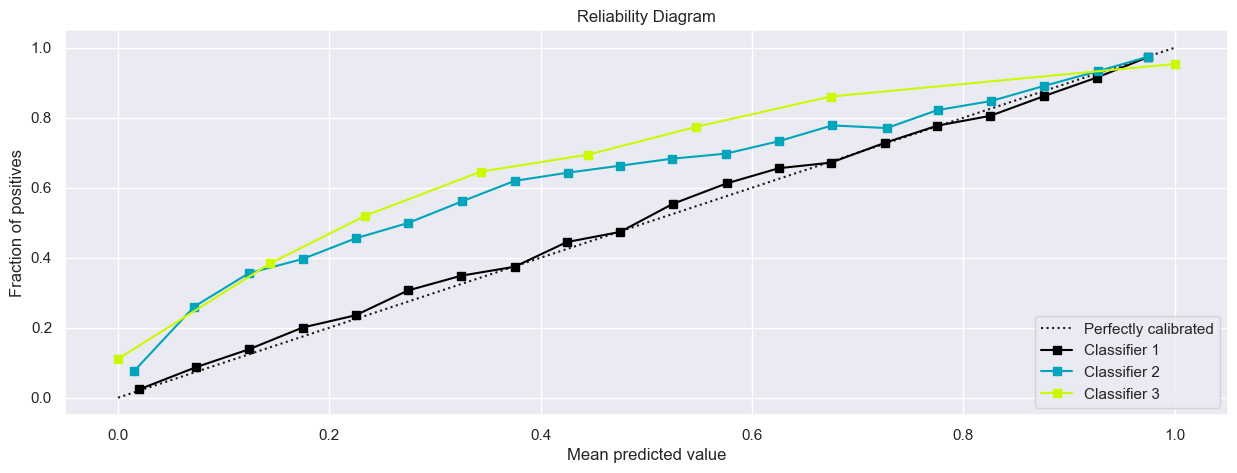

In [18]:
skplt.metrics.plot_calibration_curve(y_test, y_pred, n_bins=20)
plt.title("Reliability Diagram")
plt.show()

Plot probability distribution of every nn model

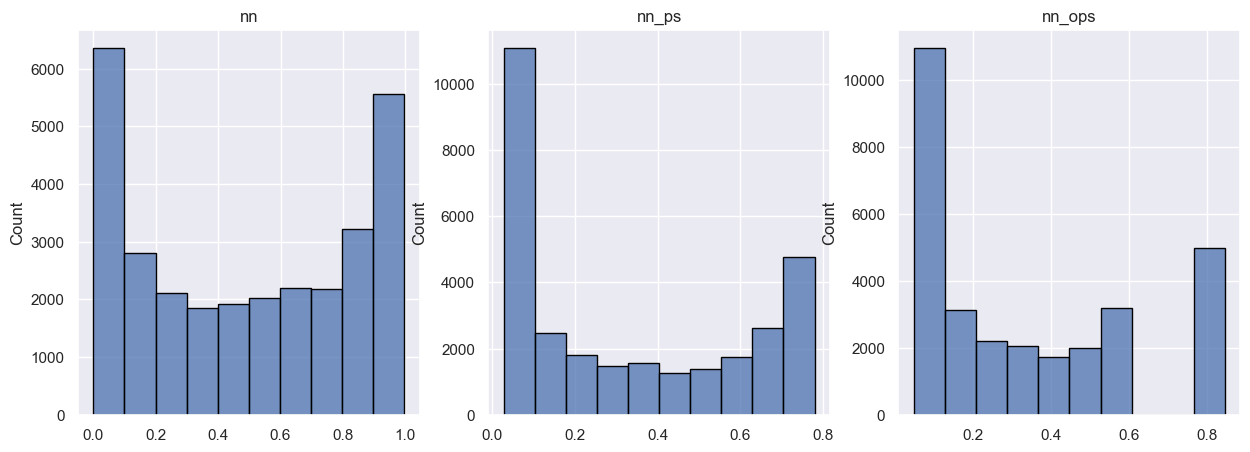

In [19]:
# plot histogram of model predictions in three separate plots in 10 bins
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (model_name, model) in enumerate(models.items()):
    sns.histplot(y_pred[i], ax=axes[i], bins=10, edgecolor="black")
    axes[i].set_title(model_name)
plt.show()

plot model statistics on accuracy and calibration

In [20]:
# plot table of models statistics containing accuracy, f1-score, brier score ECE and MCE
stats = pd.DataFrame(columns=["accuracy", "f1-score", "brier score", "ECE", "MCE"])

for i, (model_name, model) in enumerate(models.items()):
    # calculate the statistics
    acc = accuracy_score(y_test, np.round(y_pred[i]))
    f1 = f1_score(y_test, np.round(y_pred[i]))
    brier_score = brier_score_loss(y_test, y_pred[i])
    ece = expected_calibration_error(y_test, y_pred[i])
    mce = max_calibration_error(y_test, y_pred[i])

    # add the statistics to the table
    stats.loc[model_name] = [acc, f1, brier_score, ece, mce]

# Print the table
table = tabulate(stats, headers='keys', tablefmt='github')
print(table)

|        |   accuracy |   f1-score |   brier score |       ECE |       MCE |
|--------|------------|------------|---------------|-----------|-----------|
| nn     |   0.808166 |   0.808376 |      0.134104 | 0.0119619 | 0.0322983 |
| nn_ps  |   0.761706 |   0.71501  |      0.172769 | 0.172458  | 0.295904  |
| nn_ops |   0.725743 |   0.644061 |      0.176968 | 0.170239  | 0.323555  |
